In [1]:
import torch
import numpy as np
import sys; sys.path.append('../src/'); sys.path.append('..')
import matplotlib.pyplot as plt

In [2]:
from src.model.utils.metrics import l2_loss, explained_reconstruction, mean_correlation, importance_correlation, main_exprec
from src.toy_experiment import MLP, SNMLP, Adam, generate_configs, read_dataset, DataLoader, VolumeAE
from itertools import product
from torch.nn.functional import mse_loss
from math import sqrt

In [29]:
ll = [1, 2, 4, 8, 16, 32][:4]
dd = [2, 4, 8, 16, 32]
ii = range(4)
ww = [[32]*4, [64]*4, [128]*4, [256]*4, [512]*4, [1024]*4][:4]

recs = torch.zeros(len(ll), len(dd), len(ii))
mses = torch.zeros(len(ll), len(dd), len(ii))
scls = torch.zeros(len(ll), len(dd), len(ii))

for o, (l, width) in enumerate(zip(ll, ww)):
    for p, d in enumerate(dd):
        rec = []; mse = []; scl = []
        for i in ii:
            dataset = read_dataset(l, d*l, i)[:]
            # scl.append(dataset.std())
            scl.append(dataset.std(0).norm(2) / (d*l))
            configs = generate_configs(d*l, width, 'non')

            ae = VolumeAE(configs, MLP, SNMLP, Adam)
            ae.load('../saves/toy_new/{}-man/{}-amb/#{}/0e+00/non10000.tar'.format(l, l*d, i))
            ae.eval()
            
            _rec = l2_loss(ae.decode(ae.encode(dataset)), dataset) / sqrt(d*l) #/ scale
            _mse = mse_loss(ae.decode(ae.encode(dataset)), dataset) #/ (scale ** 2) 
            rec.append(_rec); mse.append(_mse)
        
        recs[o,p] = torch.as_tensor(rec)
        mses[o,p] = torch.as_tensor(mse)
        scls[o,p] = torch.as_tensor(scl)

# L2

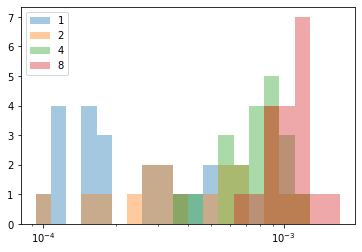

In [30]:
hist, bins = np.histogram(recs.flatten(), bins=20)
logbins = np.logspace(np.log10(bins[0]), np.log10(bins[-1]), len(bins))
for l, rec in zip(ll, recs):
    plt.hist(rec.flatten().detach().numpy(), alpha=0.4, bins=logbins, label=l)
plt.xscale('log')
plt.legend()
plt.show()

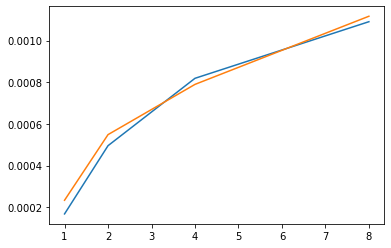

In [31]:
plt.plot(ll, recs.flatten(1).median(-1)[0])
plt.plot(ll, recs.flatten(1).mean(-1))

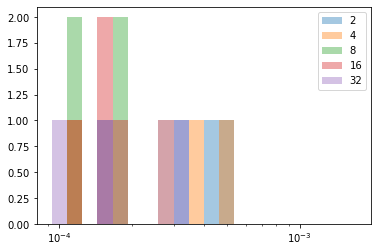

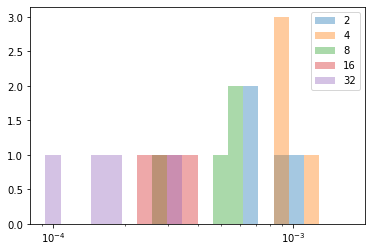

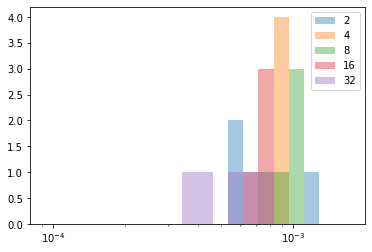

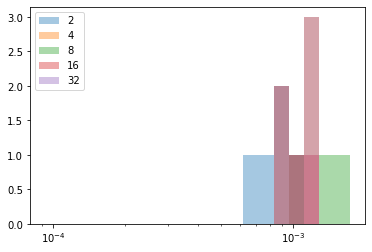

In [32]:
for rec in recs:
    for d, re in zip(dd, rec):
        plt.hist(re.flatten().detach().numpy(), alpha=0.4, bins=logbins, label=d)
    plt.xscale('log')
    plt.legend()
    plt.show()

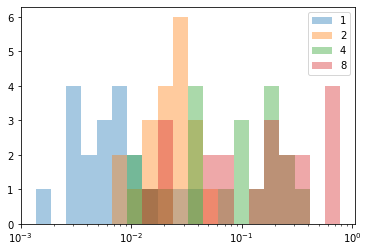

In [33]:
recs_ = recs / scls
hist, bins = np.histogram(recs_.flatten(), bins=20)
logbins = np.logspace(np.log10(bins[0]), np.log10(bins[-1]), len(bins))
for l, rec in zip(ll, recs_):
    plt.hist(rec.flatten().detach().numpy(), alpha=0.4, bins=logbins, label=l)
plt.xscale('log')
plt.legend()
plt.show()

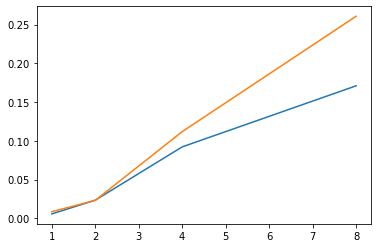

In [34]:
plt.plot(ll, recs_.flatten(1).median(-1)[0])
plt.plot(ll, recs_.flatten(1).mean(-1))

# MSE

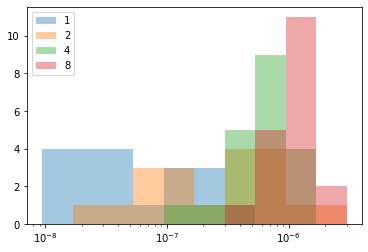

In [35]:
hist, bins = np.histogram(mses.flatten(), bins=10)
logbins = np.logspace(np.log10(bins[0]), np.log10(bins[-1]), len(bins))
for l, mse in zip(ll, mses):
    plt.hist(mse.flatten().detach().numpy(), alpha=0.4, bins=logbins, label=l)
plt.xscale('log')
plt.legend()
plt.show()

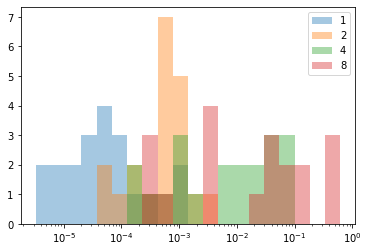

In [36]:
mses_ = mses / scls ** 2
hist, bins = np.histogram(mses_.flatten(), bins=20)
logbins = np.logspace(np.log10(bins[0]), np.log10(bins[-1]), len(bins))
for l, mse in zip(ll, mses_):
    plt.hist(mse.flatten().detach().numpy(), alpha=0.4, bins=logbins, label=l)
plt.xscale('log')
plt.legend()
plt.show()

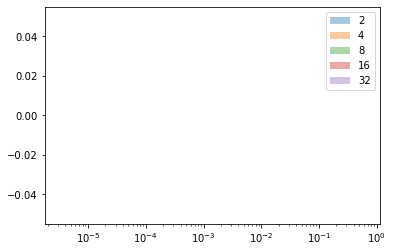

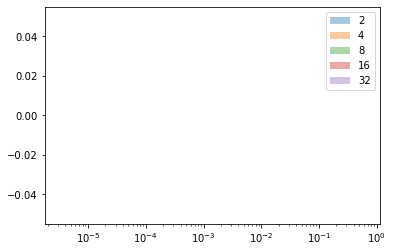

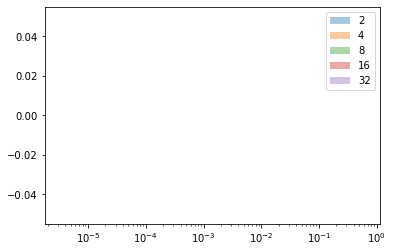

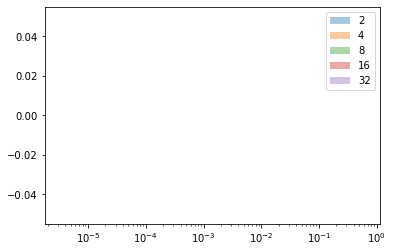

In [37]:
for mse in mses:
    for d, ms in zip(dd, mse):
        plt.hist(ms.flatten().detach().numpy(), alpha=0.4, bins=logbins, label=d)
    plt.xscale('log')
    plt.legend()
    plt.show()

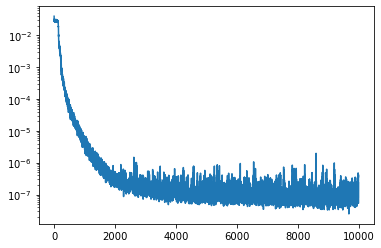

In [38]:
his = np.loadtxt('../saves/toy_new/1-man/2-amb/#0/0e+00/non_history.csv')
plt.plot(np.arange(len(his)), his)
plt.yscale('log')

In [42]:
np.save('../data/toy_new/recs.npy', recs.numpy())